In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import seaborn as sns
import tqdm
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [2]:
train_data = pd.read_csv("data/train_data/train.csv")
test_data = pd.read_csv("data/test_data.csv")

In [3]:
#handling missing data
total = test_data.isnull().sum().sort_values(ascending=False)
percent = (test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
investment_4,13894,0.987702
loan_enq,13821,0.982512
vehicle_loan_active,13712,0.974764
investment_3,13453,0.956352
investment_1,13417,0.953793
vehicle_loan_closed,13386,0.951589
investment_2,13040,0.926992
personal_loan_active,12933,0.919386
personal_loan_closed,12808,0.910500
dc_cons_jun,9064,0.644345


In [4]:
#Incidentally the > 90% cols in train and test data are same. 
# drop_cols = ['id', investment_4','loan_enq', 'investment_3','investment_1',\
#              'vehicle_loan_closed', 'investment_2' , 'personal_loan_active' ,'personal_loan_closed',
#             'vehicle_loan_active']
drop_cols = ["id", "investment_4","loan_enq","vehicle_loan_active"]
train_1 = train_data.drop(drop_cols,axis=1)
test_1 = test_data.drop(drop_cols,axis=1)

In [5]:
train_1 = train_1.fillna(0)
test_1 = test_1.fillna(0)


 mu = 9031.18 and sigma = 15720.61



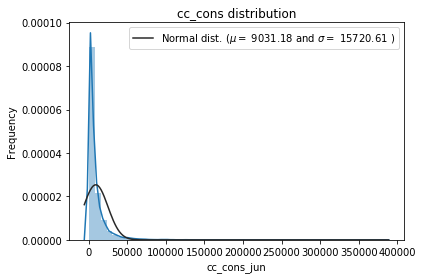

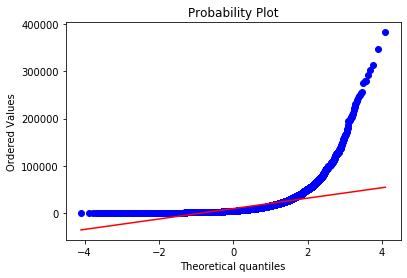

In [6]:
data = (train_1["cc_cons_jun"])
sns.distplot(data , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('cc_cons distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data, plot=plt)
plt.show()

In [7]:
train_1['cc_cons'] = np.log1p(train_1['cc_cons'])
train_1['cc_cons_apr'] = np.log1p(train_1['cc_cons_apr'])
train_1['cc_cons_may'] = np.log1p(train_1['cc_cons_may'])
train_1['cc_cons_jun'] = np.log1p(train_1['cc_cons_jun'])

test_1['cc_cons_apr'] = np.log1p(test_1['cc_cons_apr'])
test_1['cc_cons_may'] = np.log1p(test_1['cc_cons_may'])
test_1['cc_cons_jun'] = np.log1p(test_1['cc_cons_jun'])

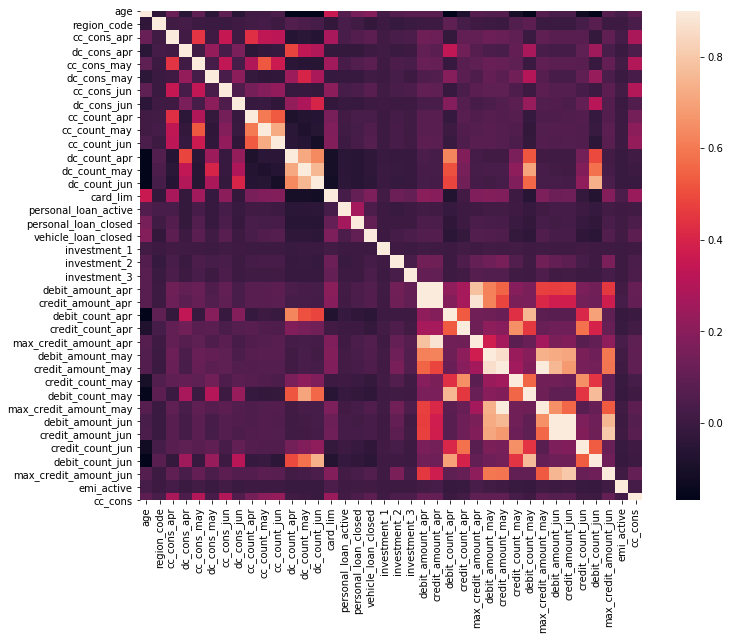

In [8]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train_1.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [24]:
def one_hot_encoder(df, cat_cols = ["account_type", "gender", "loan_enq"]):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=cat_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [26]:
cat_cols = ["account_type", "gender"]
train_1 = one_hot_encoder(train_1,cat_cols)
test_1 = one_hot_encoder(test_1,cat_cols)

Creating OHE features..
Old df shape:(32820, 40)
New df shape:(32820, 42)
Creating OHE features..
Old df shape:(14067, 39)
New df shape:(14067, 41)


In [27]:
X = train_1.drop("cc_cons", axis=1)
y = train_1["cc_cons"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=314)

In [19]:
n_fold = 5
folds = model_selection.KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [82]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    prediction_train = np.zeros(X.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            y_pred_train = model.predict(X, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)
            y_pred_train = model.predict(xgb.DMatrix(X.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)            
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X)
            

        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred
        prediction_train +=  y_pred_train
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, prediction_train, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction , prediction_train

Fold 0 started at Sun Jul 21 18:57:31 2019
Training until validation scores don't improve for 200 rounds.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's rmse: 1.14819	valid_1's rmse: 1.17011
[2000]	training's rmse: 1.12764	valid_1's rmse: 1.16721
Early stopping, best iteration is:
[2456]	training's rmse: 1.12029	valid_1's rmse: 1.1668
Fold 1 started at Sun Jul 21 18:57:33 2019
Training until validation scores don't improve for 200 rounds.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's rmse: 1.14809	valid_1's rmse: 1.16865
[2000]	training's rmse: 1.12752	valid_1's rmse: 1.16536
Early stopping, best iteration is:
[2203]	training's rmse: 1.12405	valid_1's rmse: 1.16519
Fold 2 started at Sun Jul 21 18:57:36 2019
Training until validation scores don't improve for 200 rounds.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's rmse: 1.15114	valid_1's rmse: 1.15789
[2000]	training's rmse: 1.1308	valid_1's rmse: 1.15396
Early stopping, best iteration is:
[2556]	training's rmse: 1.12192	valid_1's rmse: 1.15313
Fold 3 started at Sun Jul 21 18:57:39 2019
Training until validation scores don't improve for 200 rounds.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's rmse: 1.14521	valid_1's rmse: 1.18154
[2000]	training's rmse: 1.12462	valid_1's rmse: 1.17853
Early stopping, best iteration is:
[2753]	training's rmse: 1.11273	valid_1's rmse: 1.1782
Fold 4 started at Sun Jul 21 18:57:43 2019
Training until validation scores don't improve for 200 rounds.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's rmse: 1.15042	valid_1's rmse: 1.16096
[2000]	training's rmse: 1.13008	valid_1's rmse: 1.15625
[3000]	training's rmse: 1.11439	valid_1's rmse: 1.15505
[4000]	training's rmse: 1.10047	valid_1's rmse: 1.15485
Early stopping, best iteration is:
[3866]	training's rmse: 1.10229	valid_1's rmse: 1.1548
CV mean score: 1.1636, std: 0.0091.


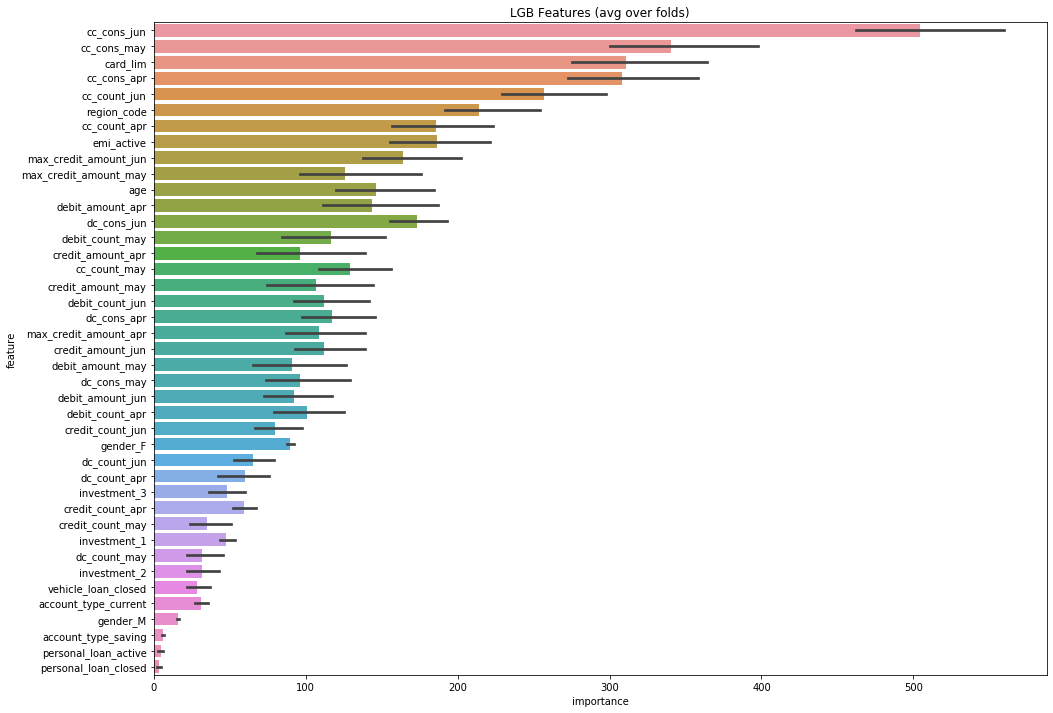

In [228]:
lgb_params = {'num_leaves': 10,
        # 'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 8,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
        'num_boost_round':15000,
        #  "bagging_seed": 11,
         "metric": 'rmse',
        # "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, prediction_lgb_1, prediction_lgb_train, feature_importance = train_model(X, test_1, y, params=lgb_params, model_type='lgb', plot_feature_importance=True)

In [51]:
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [84]:
oof_lasso_1, prediction_lasso_1, prediction_lasso_train = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False, model=linear_model.Lasso())

Fold 0 started at Sun Jul 21 17:51:42 2019
Fold 1 started at Sun Jul 21 17:51:42 2019
Fold 2 started at Sun Jul 21 17:51:42 2019
Fold 3 started at Sun Jul 21 17:51:42 2019
Fold 4 started at Sun Jul 21 17:51:43 2019
CV mean score: 1.2464, std: 0.0118.


In [85]:
oof_huber_1, prediction_huber_1, prediction_huber_train = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False, model=linear_model.HuberRegressor())

Fold 0 started at Sun Jul 21 17:51:45 2019
Fold 1 started at Sun Jul 21 17:51:46 2019
Fold 2 started at Sun Jul 21 17:51:46 2019
Fold 3 started at Sun Jul 21 17:51:47 2019
Fold 4 started at Sun Jul 21 17:51:47 2019
CV mean score: 7.2444, std: 1.9293.


In [86]:
oof_huber_1, prediction_LR_1, prediction_LR_train = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False, model=linear_model.LinearRegression())

Fold 0 started at Sun Jul 21 17:51:49 2019
Fold 1 started at Sun Jul 21 17:51:49 2019
Fold 2 started at Sun Jul 21 17:51:49 2019
Fold 3 started at Sun Jul 21 17:51:49 2019
Fold 4 started at Sun Jul 21 17:51:49 2019
CV mean score: 1.1870, std: 0.0056.


In [87]:
#oof_huber_1, prediction_RR_1 = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False, model=linear_model.ridge_regression())

In [88]:
oof_svr_1, prediction_svr_1, prediction_svr_train = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False, model=LinearSVR())

Fold 0 started at Sun Jul 21 17:51:57 2019


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold 1 started at Sun Jul 21 17:52:00 2019


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold 2 started at Sun Jul 21 17:52:04 2019


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold 3 started at Sun Jul 21 17:52:07 2019


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold 4 started at Sun Jul 21 17:52:11 2019
CV mean score: 17.3328, std: 8.0814.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [89]:
oof_svr_1, prediction_GBR_1, prediction_GBR_train = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False,\
                                          model=GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5))

Fold 0 started at Sun Jul 21 17:52:46 2019
Fold 1 started at Sun Jul 21 17:53:41 2019
Fold 2 started at Sun Jul 21 17:54:36 2019
Fold 3 started at Sun Jul 21 17:55:32 2019
Fold 4 started at Sun Jul 21 17:56:28 2019
CV mean score: 1.1784, std: 0.0087.


In [90]:
oof_svr_1, prediction_RFR_1, prediction_RFR_train = train_model(X.values, test_1.values, y.values, params=None, folds=folds, model_type='sklearn', plot_feature_importance=False,\
                                          model=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))

Fold 0 started at Sun Jul 21 17:57:28 2019
Fold 1 started at Sun Jul 21 17:57:33 2019
Fold 2 started at Sun Jul 21 17:57:37 2019
Fold 3 started at Sun Jul 21 17:57:42 2019
Fold 4 started at Sun Jul 21 17:57:46 2019
CV mean score: 1.2239, std: 0.0105.


In [311]:
df_stacked = pd.DataFrame()
df_stacked['prediction_lgb_1'] = prediction_lgb_train
df_stacked['prediction_xgb_1'] = prediction_xgb_train
df_stacked['prediction_lasso_1'] = prediction_lasso_train
df_stacked['prediction_huber_1'] = prediction_huber_train
df_stacked['prediction_GBR_1'] = prediction_GBR_train
df_stacked['prediction_RFR_1'] = prediction_RFR_train 
df_stacked['prediction_LR_1'] = prediction_LR_train

In [260]:
df_stacked.shape, y.shape

((32820, 7), (32820,))

In [312]:
X_e = df_stacked
y_e = train_1["cc_cons"]
# X_e_train, X_e_test, y_e_train, y_e_test = model_selection.train_test_split(X_e, y_e, test_size=0.10)

In [277]:
X_e_test.shape

(3282, 7)

In [278]:
y_e_test.shape

(3282,)

In [317]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=3,
#                               learning_rate=0.05, n_estimators=50000,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_params_ens = {'objective':'regression',
                  'num_leaves':6,
                  'learning_rate':0.01,
                  'num_iterations':50000,
                  'max_bin' : 55,
                  'bagging_fraction' : 0.8,
                  'bagging_freq' : 5,
                  'feature_fraction' : 0.2319,
                  'feature_fraction_seed':9,
                  'bagging_seed':9,
                  'min_data_in_leaf' :6, 'min_sum_hessian_in_leaf' : 11}

# model_lgb.fit(df_stacked, y)
# model_lgb.fit(X_e_train, y_e_train,
#               eval_set=[(X_e_train, y_e_train), (X_e_test, y_e_test)], eval_metric='rmse',
#                     verbose=1000, early_stopping_rounds=200)

_, predictions, __, ___ = train_model(X_e, predictions_stack.T, y_e, params=lgb_params_ens, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Jul 21 20:31:11 2019
Training until validation scores don't improve for 200 rounds.


/home/nilesh/anaconda3/envs/compete/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's l2: 0.826619	training's rmse: 0.909186	valid_1's l2: 0.843357	valid_1's rmse: 0.918345
[2000]	training's l2: 0.691159	training's rmse: 0.83136	valid_1's l2: 0.706846	valid_1's rmse: 0.840741
[3000]	training's l2: 0.624062	training's rmse: 0.789976	valid_1's l2: 0.639338	valid_1's rmse: 0.799586
[4000]	training's l2: 0.588113	training's rmse: 0.766885	valid_1's l2: 0.602852	valid_1's rmse: 0.776435
[5000]	training's l2: 0.564949	training's rmse: 0.751631	valid_1's l2: 0.580216	valid_1's rmse: 0.761719
[6000]	training's l2: 0.548643	training's rmse: 0.740704	valid_1's l2: 0.564062	valid_1's rmse: 0.751041
[7000]	training's l2: 0.535677	training's rmse: 0.7319	valid_1's l2: 0.551377	valid_1's rmse: 0.742548
[8000]	training's l2: 0.526347	training's rmse: 0.725498	valid_1's l2: 0.542347	valid_1's rmse: 0.736442
[9000]	training's l2: 0.518369	training's rmse: 0.719978	valid_1's l2: 0.534497	valid_1's rmse: 0.731093
[10000]	training's l2: 0.511316	training's rmse: 0.715063	

KeyboardInterrupt: 

In [296]:
predictions = model_lgb.predict(predictions_stack.T)

In [289]:
predictions_stack

(7, 14067)

In [265]:
print(df_stacked.columns , model_lgb.feature_importances_)

Index(['prediction_lgb_1', 'prediction_xgb_1', 'prediction_lasso_1',
       'prediction_huber_1', 'prediction_GBR_1', 'prediction_RFR_1',
       'prediction_LR_1'],
      dtype='object') [224 232 176 188 198 232 190]


In [266]:
importance =  list(model_lgb.feature_importances_)
average_importance = [val/sum(importance) for val in importance]
    
models = df_stacked.columns
model_importance = dict(zip(models, (average_importance)))

In [267]:
model_importance

{'prediction_lgb_1': 0.15555555555555556,
 'prediction_xgb_1': 0.16111111111111112,
 'prediction_lasso_1': 0.12222222222222222,
 'prediction_huber_1': 0.13055555555555556,
 'prediction_GBR_1': 0.1375,
 'prediction_RFR_1': 0.16111111111111112,
 'prediction_LR_1': 0.13194444444444445}

In [310]:
predictions_stack = np.stack((prediction_lgb_1, 
                              prediction_xgb_1, 
                              prediction_lasso_1,\
#                              prediction_huber_1, \
                              prediction_GBR_1, 
                              prediction_RFR_1,
                              prediction_LR_1
                             ) , axis = 0)

model_predictions = dict(zip(models, predictions_stack))

In [272]:
predictions_stack.shape

(7, 14067)

In [273]:
predictions = np.zeros(test_1.shape[0])

for model in models:
    predictions += model_importance[model]*model_predictions[model]

In [291]:
def create_submission(data, name):
    sample_submission=pd.read_csv("data/sample_submission.csv")
    sample_submission['cc_cons'] = data
    sample_submission.to_csv(name, index=False, quoting=3 )

In [316]:
create_submission(np.expm1(predictions), "sample_submission_ensemble_2.csv")